In [1]:
!python --version

Python 3.9.16


In [2]:
#!pip install pyspark

In [8]:
import pandas as pd
import numpy as np

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

#import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

# Machine Learning

In [11]:
# Import the vectorAssembler class
from pyspark.ml.feature import VectorAssembler

In [12]:
#tele_df.to_parquet('./parq_test.parquet')

In [13]:
%%time
tele_sdf = spark.read.csv("tele_df.csv", header=True, inferSchema=True)

CPU times: total: 0 ns
Wall time: 18 s


In [14]:
# to show dataframe properly in jupyter
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
display(tele_sdf.limit(5))

_c0,age,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals
0,58,8,no,yes,no,cellular,2008-05-05 00:00:00,261,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,8,3
1,44,7,no,yes,no,cellular,2008-05-05 00:00:00,151,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,6,2
2,33,7,no,yes,yes,cellular,2008-05-05 00:00:00,76,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,11,3
3,47,7,no,yes,no,cellular,2008-05-05 00:00:00,92,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,5,3
4,33,7,no,no,no,cellular,2008-05-05 00:00:00,198,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,5,2


In [15]:
tele_sdf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- jobs: integer (nullable = true)
 |-- maritals: integer (nullable = true)



In [16]:
#!dir

In [17]:
column_lst = tele_sdf.columns
print(column_lst)

['_c0', 'age', 'education', 'default', 'housing', 'loan', 'contact', 'date', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'y', 'jobs', 'maritals']


In [18]:
tele_sdf.schema["poutcome"].dataType

StringType()

In [19]:
hot_lst = [ x for x in tele_sdf.columns if tele_sdf.schema[x].dataType == StringType() ]
hot_lst[:-1]

['default', 'housing', 'loan', 'contact', 'poutcome']

In [20]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col

def one_hot_encode(data, columns):
    new_data = data.select("*")
    for col_name in columns:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
        new_data = indexer.fit(new_data).transform(new_data)

        encoder = OneHotEncoder(inputCols=[f"{col_name}_index"], outputCols=[f"{col_name}_one_hot"], dropLast=True)
        new_data = encoder.fit(new_data).transform(new_data)

        new_data = new_data.drop(col_name).drop(f"{col_name}_index")

    return new_data

In [21]:
tele_sdf_ohe = one_hot_encode(data = tele_sdf, columns = hot_lst[:-1])
tele_sdf_ohe.show()

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+
|  0| 58|        8|2008-05-05 00:00:00|     261|       1|   -1|       0|         1.1|        93.994|        -36.4|      4.85|     5191.0| no|   8|       3|  (1,[0],[1.0])|  (1,[0],[1.0])|(1,[0],[1.0])|  (1,[0],[1.0])|   (2,[0],[1.0])|
|  1| 44|        7|2008-05-05 00:00:00|     151|       1|   

In [22]:
tele_sdf_ohe.columns

['_c0',
 'age',
 'education',
 'date',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor_3m',
 'nr_employed',
 'y',
 'jobs',
 'maritals',
 'default_one_hot',
 'housing_one_hot',
 'loan_one_hot',
 'contact_one_hot',
 'poutcome_one_hot']

In [23]:
# Label encoding for y
#import required libraries
from pyspark.ml.feature import StringIndexer
y_indexer = StringIndexer(inputCol="y", outputCol="yIndex")#Fits a model to the input dataset with optional parameters.
tele_sdf_ohey = y_indexer.fit(tele_sdf_ohe).transform(tele_sdf_ohe)
tele_sdf_ohey.show()

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+
|  0| 58|        8|2008-05-05 00:00:00|     261|       1|   -1|       0|         1.1|        93.994|        -36.4|      4.85|     5191.0| no|   8|       3|  (1,[0],[1.0])|  (1,[0],[1.0])|(1,[0],[1.0])|  (1,[0],[1.0])|   (2,[0],[1.0])|   0.0|
|  1| 44|        7|2008-05-05 00

In [24]:
tele_sdf_ohey.groupby('yIndex').count().show()

+------+-----+
|yIndex|count|
+------+-----+
|   0.0|76470|
|   1.0| 9929|
+------+-----+



In [25]:
features_lst = [ 'age',
 'education',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor_3m',
 'nr_employed',
 'jobs',
 'maritals',
 'default_one_hot',
 'housing_one_hot',
 'loan_one_hot',
 'contact_one_hot',
 'poutcome_one_hot']

In [26]:
assembler = VectorAssembler(inputCols = features_lst, outputCol = 'features')

In [27]:
tele_transform = assembler.transform(tele_sdf_ohey)

In [28]:
tele_transform

_c0,age,education,date,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals,default_one_hot,housing_one_hot,loan_one_hot,contact_one_hot,poutcome_one_hot,yIndex,features
0,58,8,2008-05-05 00:00:00,261,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,8,3,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[58.0,8.0,261.0,1..."
1,44,7,2008-05-05 00:00:00,151,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,6,2,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[44.0,7.0,151.0,1..."
2,33,7,2008-05-05 00:00:00,76,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,11,3,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[],[])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[33.0,7.0,76.0,1...."
3,47,7,2008-05-05 00:00:00,92,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,5,3,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[47.0,7.0,92.0,1...."
4,33,7,2008-05-05 00:00:00,198,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,5,2,"(1,[0],[1.0])","(1,[],[])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[33.0,7.0,198.0,1..."
5,35,8,2008-05-05 00:00:00,139,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,8,3,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[35.0,8.0,139.0,1..."
6,28,8,2008-05-05 00:00:00,217,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,8,2,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[],[])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[28.0,8.0,217.0,1..."
7,42,8,2008-05-05 00:00:00,380,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,11,1,"(1,[],[])","(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[42.0,8.0,380.0,1..."
8,58,3,2008-05-05 00:00:00,50,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,3,3,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[58.0,3.0,50.0,1...."
9,43,7,2008-05-05 00:00:00,55,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,no,6,2,"(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(1,[0],[1.0])","(2,[0],[1.0])",0.0,"[43.0,7.0,55.0,1...."


## Split the data into train test and split

In [29]:
train_data, test_data = tele_transform.randomSplit([0.85, 0.15],
                                                   seed = 14)

In [30]:
print( "Train:",train_data.count(), "\t Test: ", test_data.count())

Train: 73433 	 Test:  12966


In [31]:
train_data.groupby('yIndex').count().show()

+------+-----+
|yIndex|count|
+------+-----+
|   0.0|64958|
|   1.0| 8475|
+------+-----+



In [32]:
test_data.groupby('yIndex').count().show()

+------+-----+
|yIndex|count|
+------+-----+
|   0.0|11512|
|   1.0| 1454|
+------+-----+



In [33]:
test_data.show()

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|            features|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+
|  4| 33|        7|2008-05-05 00:00:00|     198|       1|   -1|       0|         1.1|        93.994|        -36.4|      4.85|     5191.0| no|   5|       2|  (1,[0],[1.0])|      (1,[],[])|(1,[0],[1.0])|  (1,[0],[

## Using Decision Tree

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier

In [35]:
dt = DecisionTreeClassifier(labelCol='yIndex', featuresCol = 'features')

### Train Algorithm

In [36]:
# train the algorithm
dt_model = dt.fit(train_data)

In [37]:
# Predictions on unseen data
predictions = dt_model.transform(test_data)

In [38]:
predictions.show(3)

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+----------------+--------------------+----------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|            features|   rawPrediction|         probability|prediction|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+----------------+--------------------+----------+
|  4| 33|        7|2008-05-05 00:00:00|     198|       1|   -1| 

In [39]:
dt_pred = predictions.select('prediction').toPandas()
actual = predictions.select('yIndex').toPandas()

In [40]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

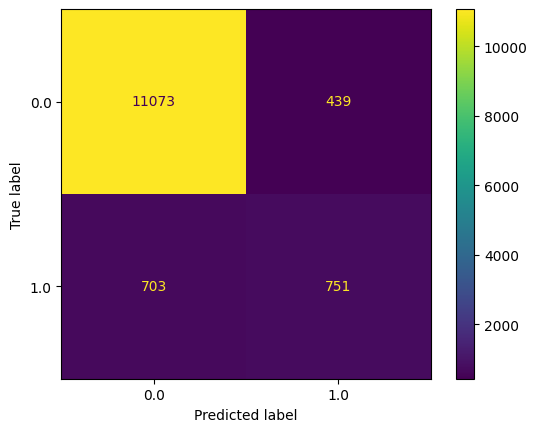

In [41]:
ConfusionMatrixDisplay.from_predictions(actual, dt_pred)

In [42]:
print(classification_report(actual, dt_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     11512
         1.0       0.63      0.52      0.57      1454

    accuracy                           0.91     12966
   macro avg       0.79      0.74      0.76     12966
weighted avg       0.91      0.91      0.91     12966



### Check for accuracy

In [43]:
# import
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [44]:
eval = MulticlassClassificationEvaluator(labelCol = 'yIndex',
                                         metricName = 'accuracy')

In [45]:
print('Accuracy', eval.evaluate(predictions))

Accuracy 0.9119234922103964


## Using Logistic Regression

In [46]:
from pyspark.ml.classification import LogisticRegression

In [47]:
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'yIndex',
                        maxIter=1000)

In [48]:
lr_model = lr.fit(train_data)

In [49]:
lr_predictions = lr_model.transform(test_data)

In [50]:
lr_predictions.show(5)

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+--------------------+--------------------+----------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|            features|       rawPrediction|         probability|prediction|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+--------------------+--------------------+----------+
|  4| 33|        7|2008-05-05 00:00:00|     198|    

In [51]:
lr_pred = lr_predictions.select('prediction').toPandas()

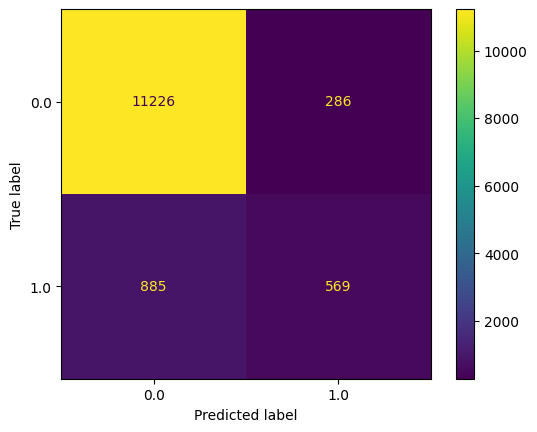

In [52]:
ConfusionMatrixDisplay.from_predictions(actual, lr_pred)

In [53]:
eval_lr = MulticlassClassificationEvaluator(labelCol = 'yIndex',
                                         metricName = 'accuracy')

In [54]:
print('Accuracy', eval_lr.evaluate(lr_predictions))

Accuracy 0.9096868733610982


## Oversampling to reduce imbalance in _'yIndex'_

In [ ]:
# Implement oversampling method
import pyspark.sql.functions as F
import math
# only take needed columns to model
ml_df = tele_transform.select('yIndex','features')

In [58]:
ml_df.show()

+------+--------------------+
|yIndex|            features|
+------+--------------------+
|   0.0|[58.0,8.0,261.0,1...|
|   0.0|[44.0,7.0,151.0,1...|
|   0.0|[33.0,7.0,76.0,1....|
|   0.0|[47.0,7.0,92.0,1....|
|   0.0|[33.0,7.0,198.0,1...|
|   0.0|[35.0,8.0,139.0,1...|
|   0.0|[28.0,8.0,217.0,1...|
|   0.0|[42.0,8.0,380.0,1...|
|   0.0|[58.0,3.0,50.0,1....|
|   0.0|[43.0,7.0,55.0,1....|
|   0.0|[41.0,7.0,222.0,1...|
|   0.0|[29.0,7.0,137.0,1...|
|   0.0|[53.0,7.0,517.0,1...|
|   0.0|[58.0,7.0,71.0,1....|
|   0.0|[57.0,7.0,174.0,1...|
|   0.0|[51.0,3.0,353.0,1...|
|   0.0|[45.0,7.0,98.0,1....|
|   0.0|[57.0,3.0,38.0,1....|
|   0.0|[60.0,3.0,219.0,1...|
|   0.0|[33.0,7.0,54.0,1....|
+------+--------------------+
only showing top 20 rows



In [76]:
# calculate ratio
major_df = ml_df.filter(ml_df.yIndex == "0.00")
minor_df = ml_df.filter(ml_df.yIndex == "1.00")
ratio = int(math.ceil(minor_df.count()/major_df.count()*100*1.7))
print("ratio: {}".format(ratio))
a = range(ratio)

ratio: 23


In [77]:
print(minor_df.count()/major_df.count()*100*1.7)

22.073100562312018


In [74]:
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

In [78]:
display(combined_df.limit(7))

yIndex,features
0.0,"[58.0,8.0,261.0,1..."
0.0,"[44.0,7.0,151.0,1..."
0.0,"[33.0,7.0,76.0,1...."
0.0,"[47.0,7.0,92.0,1...."
0.0,"[33.0,7.0,198.0,1..."
0.0,"[35.0,8.0,139.0,1..."
0.0,"[28.0,8.0,217.0,1..."


In [75]:
combined_df.groupby("yIndex").count().show()

+------+------+
|yIndex| count|
+------+------+
|   0.0| 76470|
|   1.0|129077|
+------+------+



In [ ]:
# split dataframe into train and test datasets
train, test = combined_df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
from pyspark.ml.feature import Normalizer, StandardScaler
from pyspark.ml import Pipeline
# LogisticRegression

# create transformers
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
normalizer = Normalizer(inputCol='scaled_features',outputCol='norm_scaled_features')

# set regression model
logreg =  LogisticRegression(labelCol="yIndex", featuresCol="features",maxIter=10, regParam=0.0, elasticNetParam=0)

# create pipeline
pipeline = Pipeline(stages=[logreg])

# run CV on train data
lr_pipe = pipeline.fit(train)

# create prediction column on test data
results = lr_pipe.transform(test)

# evaluate results
correct_count = results.filter(results.yIndex == results.prediction).count()
total_count = results.count()

correct_1_count = results.filter((results.yIndex == 1) & (results.prediction == 1)).count()
total_1_test = results.filter((results.yIndex == 1)).count()
total_1_predict = results.filter((results.prediction == 1)).count()

print("All correct predections count: ",correct_count)
print("Total count: ",total_count)
print("Accuracy %: ",(correct_count / total_count)*100)
print("Recall %: ",(correct_1_count / total_1_test)*100)
print("Precision %: ",(correct_1_count / total_1_predict)*100)

In [56]:
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier
# RandomForestClassifier

# set rf model
rf =  RandomForestClassifier(labelCol="yIndex", featuresCol="features")

# instantiate pipeline
pipeline = Pipeline(stages=[rf])

# train model
model_rf = pipeline.fit(train)

# create prediction column on test data
results = model_rf.transform(test)

# evaluate results
correct_count = results.filter(results.yIndex == results.prediction).count()
total_count = results.count()

correct_1_count = results.filter((results.yIndex == 1) & (results.prediction == 1)).count()
total_1_test = results.filter((results.yIndex == 1)).count()
total_1_predict = results.filter((results.prediction == 1)).count()

print("All correct predections count: ",correct_count)
print("Total count: ",total_count)
print("Accuracy %: ",(correct_count / total_count)*100)
print("Recall %: ",(correct_1_count / total_1_test)*100)
print("Precision %: ",(correct_1_count / total_1_predict)*100)

All correct predections count:  298454
Total count:  301340
Accuracy %:  99.04227782571182
Recall %:  0.0


ZeroDivisionError: division by zero